In [1]:
import nibabel as nib
import numpy as np
import os

labs = False
if labs:
    # Define the path to the tractograms to evaluate
    results_path = "/media/hsa22/Expansion/residual_results"
else:
    results_path = "/mnt/d/residual_results"

# Define path to the ground truth stuff
b0_path = os.path.join(results_path, "cut_b0.nii")
residual_path = os.path.join(results_path, "cut_res.nii")

# Define path to the predictions to evaluate
resnet_path = os.path.join(results_path, "resnetTDI_final_train.nii")
attnunet_path = os.path.join(results_path, "attnunetTDI_final_train.nii")
efficientnet_path = os.path.join(results_path, "efficientnetTDI_final_train.nii")

## **Load and Normalize the images**

In [2]:
import SimpleITK as sitk

# Function to normalize an image
def normalize_image(image):

    # Read the image using SimpleITK
    reader = sitk.ImageFileReader()
    reader.SetFileName(image)
    image = reader.Execute()
    
    # Define the normalizer
    normalizer = sitk.NormalizeImageFilter()
    rescaler = sitk.RescaleIntensityImageFilter()
    
    # Set the maximum and minimum of rescaler
    rescaler.SetOutputMaximum(255)
    rescaler.SetOutputMinimum(0)
    
    # Normalize the image (mean and std)
    image = normalizer.Execute(image)
    
    # Rescale the image (0 -> 255)
    image = rescaler.Execute(image)

    # Get the data from the image
    image_data = np.transpose(sitk.GetArrayFromImage(image), axes=(2, 1, 0))
    
    # Return the image
    return image, image_data

In [3]:
# Load and normalize the ground truth
b0_img, b0 = normalize_image(b0_path)
residual_img, residual = normalize_image(residual_path)

# Load and normalize the predictions
resnet_img, resnet = normalize_image(resnet_path)
attnunet_img, attnunet = normalize_image(attnunet_path)
efficientnet_img, efficientnet = normalize_image(efficientnet_path)

print("Shape of b0: ", b0.shape)
print("Shape of residual: ", residual.shape)
print("Shape of resnet: ", resnet.shape)
print("Shape of attnunet: ", attnunet.shape)
print("Shape of efficientnet: ", efficientnet.shape)

Shape of b0:  (64, 178, 115)
Shape of residual:  (64, 178, 115)
Shape of resnet:  (65, 181, 117)
Shape of attnunet:  (65, 185, 121)
Shape of efficientnet:  (65, 185, 121)


## **Get the Difference Between the Prediction and B0/Residual**

In [4]:
# Function to find the difference between prediction and b0/residual
def find_diff(pred, gt_b0, gt_res):

    # Get the size of the GT
    gt_x, gt_y, gt_z = gt_b0.shape

    # Get the prediction only until the size of the GT
    pred = pred[:gt_x, :gt_y, :gt_z]

    # Find the difference
    diff_b0 = abs(pred - gt_b0)
    diff_res = abs(pred - gt_res)

    # Return the difference
    return diff_b0, diff_res

# Find the difference between the predictions and the ground truth
diff_resnet_b0, diff_resnet_res = find_diff(resnet, b0, residual)
diff_attnunet_b0, diff_attnunet_res = find_diff(attnunet, b0, residual)
diff_efficientnet_b0, diff_efficientnet_res = find_diff(efficientnet, b0, residual)

print("Shape of diff_resnet_b0: ", diff_resnet_b0.shape, " and diff_resnet_res: ", diff_resnet_res.shape)
print("Shape of diff_attnunet_b0: ", diff_attnunet_b0.shape, " and diff_attnunet_res: ", diff_attnunet_res.shape)
print("Shape of diff_efficientnet_b0: ", diff_efficientnet_b0.shape, " and diff_efficientnet_res: ", diff_efficientnet_res.shape)

Shape of diff_resnet_b0:  (64, 178, 115)  and diff_resnet_res:  (64, 178, 115)
Shape of diff_attnunet_b0:  (64, 178, 115)  and diff_attnunet_res:  (64, 178, 115)
Shape of diff_efficientnet_b0:  (64, 178, 115)  and diff_efficientnet_res:  (64, 178, 115)


In [5]:
# Get the mean and std of the difference
def get_mean_std(diff_b0, diff_res):
    
        # Get the mean and std of b0
        mean_b0 = round(np.mean(diff_b0), 2)
        std_b0 = round(np.std(diff_b0), 2)

        # Get the mean and std of the residual
        mean_res = round(np.mean(diff_res), 2)
        std_res = round(np.std(diff_res), 2)

        # Get the median of the difference
        median_b0 = round(np.median(diff_b0), 2)
        median_res = round(np.median(diff_res), 2)
    
        # Return the mean and std
        return mean_b0, std_b0, mean_res, std_res, median_b0, median_res

# Get the mean and std of the difference for each model
(mean_resnet_b0, std_resnet_b0, mean_resnet_res, std_resnet_res, 
 median_resnet_b0, median_resnet_res) = get_mean_std(diff_resnet_b0, diff_resnet_res)
(mean_attnunet_b0, std_attnunet_b0, mean_attnunet_res, std_attnunet_res, 
 median_attnunet_b0, median_attnunet_res) = get_mean_std(diff_attnunet_b0, diff_attnunet_res)
(mean_efficientnet_b0, std_efficientnet_b0, mean_efficientnet_res, 
 std_efficientnet_res, median_efficientnet_b0, median_efficientnet_res)  = get_mean_std(diff_efficientnet_b0, diff_efficientnet_res)

print("Mean and std of diff_resnet_b0: ", mean_resnet_b0, " +/-", std_resnet_b0, "| \
        diff_resnet_res: ", mean_resnet_res, " +/-", std_resnet_res)
print("Mean and std of diff_attnunet_b0: ", mean_attnunet_b0, " +/-", std_attnunet_b0, "| \
        diff_attnunet_res: ", mean_attnunet_res, " +/-", std_attnunet_res)
print("Mean and std of diff_efficientnet_b0: ", mean_efficientnet_b0, " +/-", std_efficientnet_b0, "| \
        diff_efficientnet_res: ", mean_efficientnet_res, " +/-", std_efficientnet_res)

print("-------------------------------------")

print("Median of diff_resnet_b0: ", median_resnet_b0, " | diff_resnet_res: ", median_resnet_res)
print("Median of diff_attnunet_b0: ", median_attnunet_b0, " | diff_attnunet_res: ", median_attnunet_res)
print("Median of diff_efficientnet_b0: ", median_efficientnet_b0, " | diff_efficientnet_res: ", median_efficientnet_res)

Mean and std of diff_resnet_b0:  50.13  +/- 35.2 |         diff_resnet_res:  56.12  +/- 35.01
Mean and std of diff_attnunet_b0:  53.26  +/- 55.06 |         diff_attnunet_res:  9.79  +/- 24.42
Mean and std of diff_efficientnet_b0:  53.26  +/- 55.06 |         diff_efficientnet_res:  9.79  +/- 24.42
-------------------------------------
Median of diff_resnet_b0:  43.19  | diff_resnet_res:  50.43
Median of diff_attnunet_b0:  29.71  | diff_attnunet_res:  1.18
Median of diff_efficientnet_b0:  29.71  | diff_efficientnet_res:  1.18


In [6]:
# Define the mean, std, and mean distances into a list for looping
B0_means = [mean_resnet_b0, mean_attnunet_b0, mean_efficientnet_b0]
B0_stds = [std_resnet_b0, std_attnunet_b0, std_efficientnet_b0]
B0_medians = [median_resnet_b0, median_attnunet_b0, median_efficientnet_b0]
B0_differences = [diff_resnet_b0.flatten(), diff_attnunet_b0.flatten(), diff_efficientnet_b0.flatten()]
RES_means = [mean_resnet_res, mean_attnunet_res, mean_efficientnet_res]
RES_stds = [std_resnet_res, std_attnunet_res, std_efficientnet_res]
RES_medians = [median_resnet_res, median_attnunet_res, median_efficientnet_res]
RES_differences = [diff_resnet_res.flatten(), diff_attnunet_res.flatten(), diff_efficientnet_res.flatten()]

Beige color:  (0.9029752854391232, 0.889043468368151, 0.9192755298057348)
Pinkish color:  [0.6057777926703288, 0.538425109849222, 0.7719065036737998]
Purpleish color:  [0.40984696263311027, 0.22269824285815243, 0.3972122365869202]
Row: 00 | Col: 00 | Mean: 50.13 | Std: 35.20 | Max prob: [0.0065, 0.0115, 0.0065]
Row: 00 | Col: 01 | Mean: 56.12 | Std: 35.01 | Max prob: [0.0065, 0.0115, 0.0065]
Row: 01 | Col: 00 | Mean: 53.26 | Std: 55.06 | Max prob: [0.005, 0.007, 0.005]
Row: 01 | Col: 01 | Mean: 09.79 | Std: 24.42 | Max prob: [0.005, 0.007, 0.005]
Row: 02 | Col: 00 | Mean: 53.26 | Std: 55.06 | Max prob: [0.005, 0.007, 0.005]
Row: 02 | Col: 01 | Mean: 09.79 | Std: 24.42 | Max prob: [0.005, 0.007, 0.005]


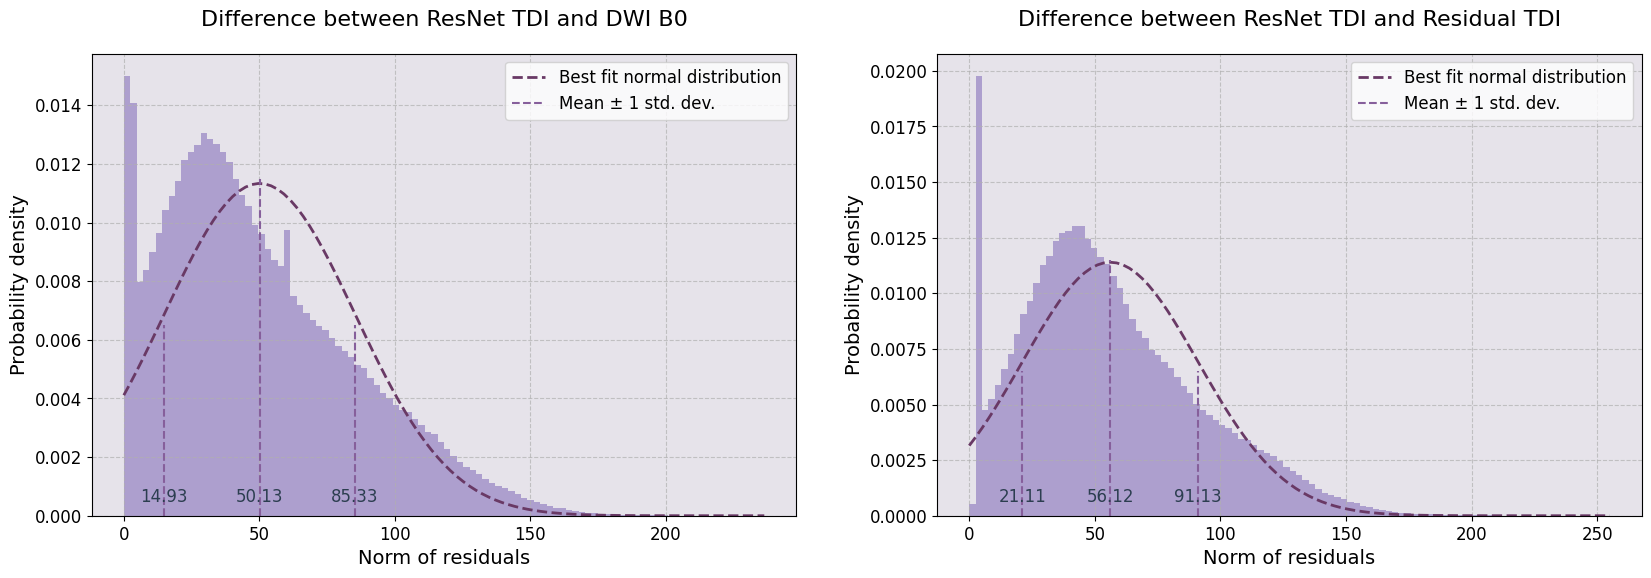

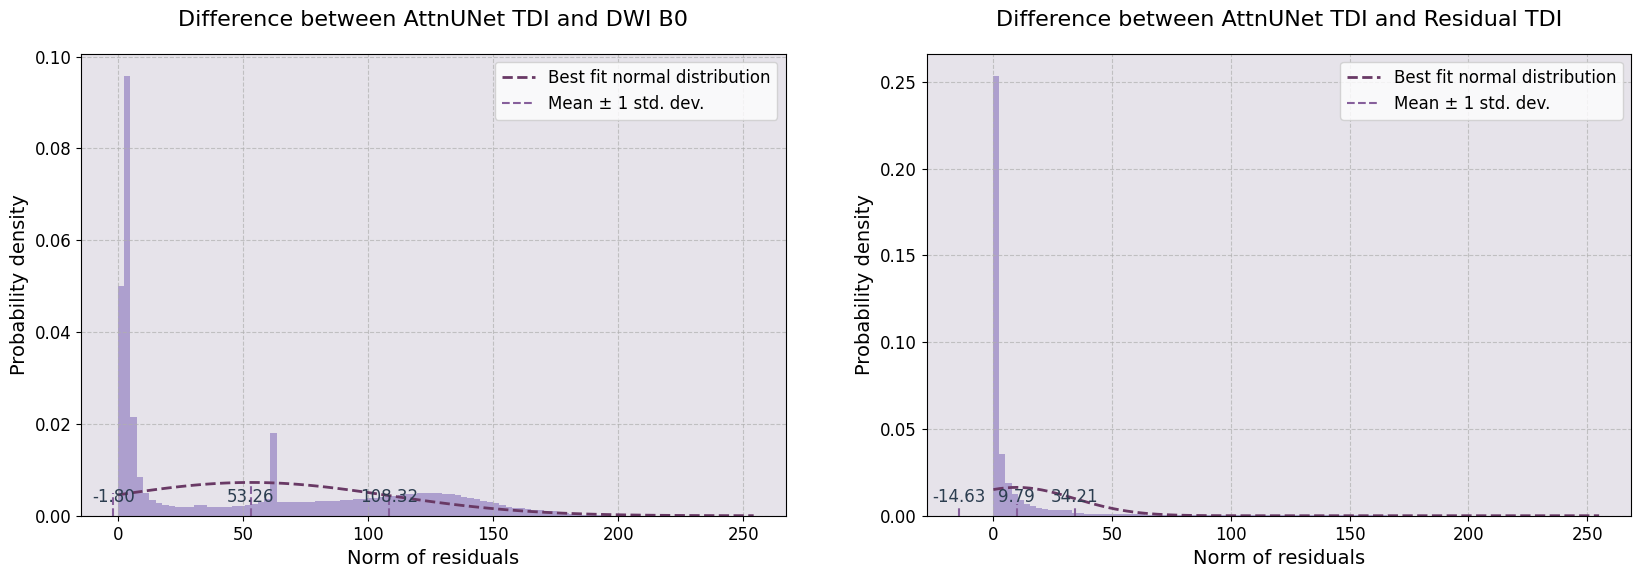

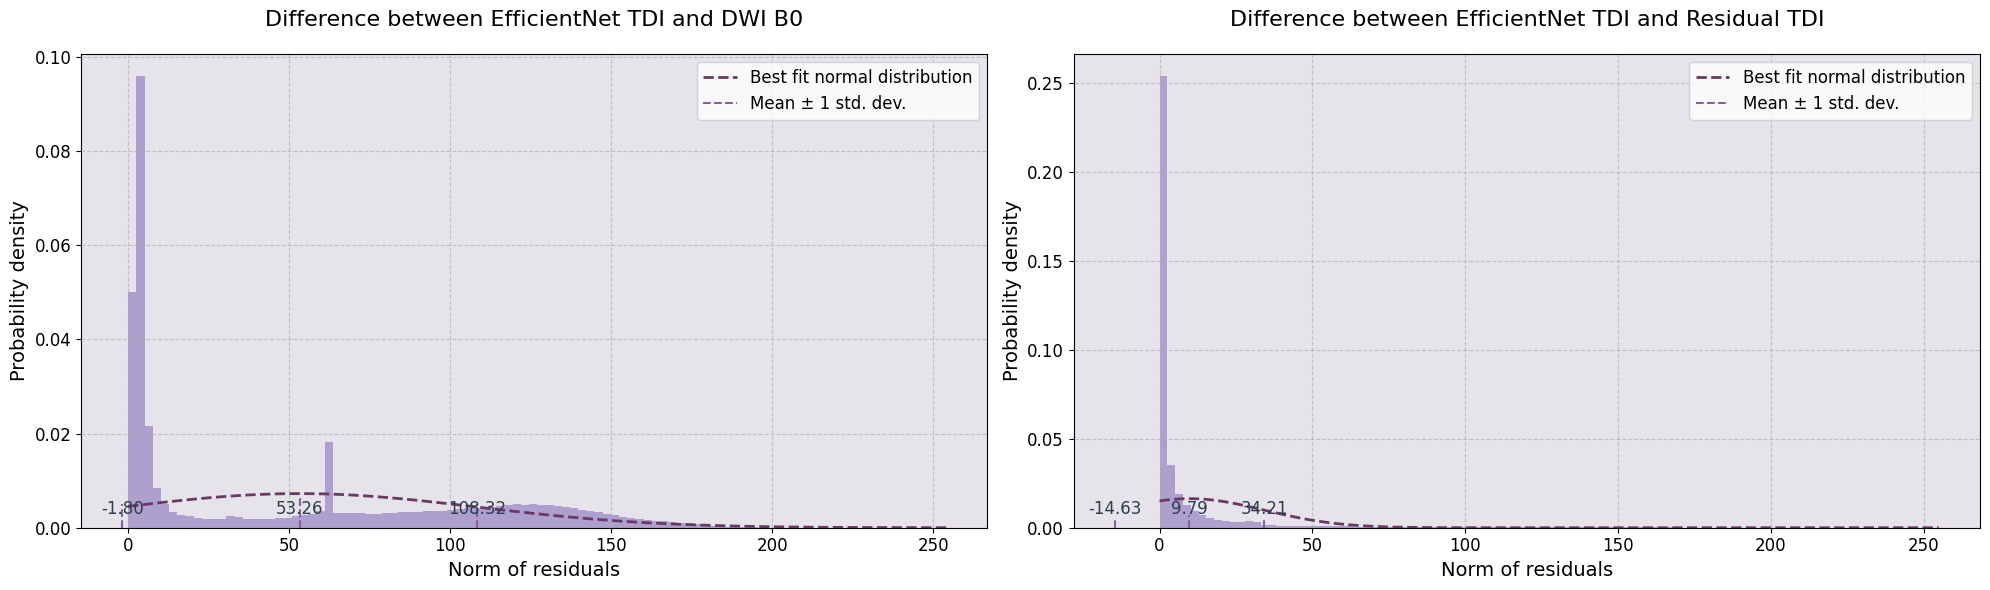

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Generate a cubehelix color palette with pinkish and purpleish tones
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.3, light=0.8)
pinkish = color_palette[3]  # Picking the light pink color from the palette
purpleish = color_palette[7]  # Picking the light purple color from the palette
inbetween = color_palette[5]  # Picking the light purple color from the palette

# Soft color palette
hist_color = pinkish  # blue
line_color = purpleish  # red
mean_color = '#2c3e50'  # dark gray
annotation_color = inbetween  # orange
beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]  # Picking a lighter shade from the generated beige palette

print("Beige color: ", beige_color)
print("Pinkish color: ", pinkish)
print("Purpleish color: ", purpleish)


# Lists to loop over
conditions = [('DWI B0', B0_differences, B0_means, B0_stds, B0_medians), ('Residual TDI', RES_differences, RES_means, RES_stds, RES_medians)]
prob_maxes = [
    [0.0065, 0.0115, 0.0065],  # ResNet
    [0.005, 0.007, 0.005],  # AttnUNet
    [0.005, 0.007, 0.005]   # EfficientNet
]

model_names = ['ResNet', 'AttnUNet', 'EfficientNet']

for row in range(3):  # Looping over 3 models
    # Set up the figure and axes for each model
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    for col, (label, differences, means, stds, medians) in enumerate(conditions):
        ax = axes[col]  # Now just select the column because there's only one row

        diff = differences[row]
        mean = means[row]
        std = stds[row]
        median = medians[row]
        max_prob = prob_maxes[row]

        print("Row: {:02} | Col: {:02} | Mean: {:05.2f} | Std: {:05.2f} | Max prob: {}".format(row, col, mean, std, max_prob))

        # Histogram of residuals
        n, bins, patches = ax.hist(diff, bins=100, density=True, color=hist_color, alpha=0.75)

        # Add a 'best fit' line
        y = norm.pdf(bins, mean, std)
        ax.plot(bins, y, '--', color=line_color, linewidth=2, label='Best fit normal distribution')

        # Add vertical lines for the mean and one standard deviation on either side
        ax.vlines(mean - std, 0, max_prob[0], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean, 0, max_prob[1], color=annotation_color, linestyle='dashed', linewidth=1.5)
        ax.vlines(mean + std, 0, max_prob[2], color=annotation_color, linestyle='dashed', linewidth=1.5, label='Mean ± 1 std. dev.')

        # Annotate the mean and std values on the x-axis
        ax.annotate(f'{mean:.2f}', (mean, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean + std:.2f}', (mean + std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
        ax.annotate(f'{mean - std:.2f}', (mean - std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)

        # Improve labels and title
        ax.set_xlabel('Norm of residuals', fontsize=14)
        ax.set_ylabel('Probability density', fontsize=14)
        ax.set_title(f'Difference between {model_names[row]} TDI and {label}', fontsize=16, pad=20)

        # Adding a grid for better readability
        ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

        # Position the legend optimally and set its fontsize
        ax.legend(loc='upper right', fontsize=12)

        # Set the background color
        ax.set_facecolor(beige_color)

        # Increase tick font size
        ax.tick_params(axis='both', labelsize=12)

# Ensure everything fits without clipping
fig.tight_layout()

# Display the plot
plt.show()

        

## **Get the SSIM Between B0 and Residual TDI**

In [12]:
from ssim_funcs import *

# Find to return the SSIM between two images
def find_SSIM(pred, gt):

    # Get the size of the GT
    gt_x, gt_y, gt_z = gt.shape

    # Get the prediction only until the size of the GT
    pred = pred[:gt_x, :gt_y, :gt_z]

    # Turn them into torch tensors
    pred_tensor = torch.from_numpy(pred).unsqueeze(0).unsqueeze(0).float()
    gt_tensor = torch.from_numpy(gt).unsqueeze(0).unsqueeze(0).float()

    # Find the SSIM
    ssim = ssim3D(pred_tensor, gt_tensor).item()

    # Round the SSIM
    ssim = round(ssim, 8)

    # Return the SSIM
    return ssim

# Get the SSIM between the predictions and the ground truth
ssim_resnet_b0, ssim_resnet_res = find_SSIM(resnet, b0), find_SSIM(resnet, residual)
ssim_attnunet_b0, ssim_attnunet_res = find_SSIM(attnunet, b0), find_SSIM(attnunet, residual)
ssim_efficientnet_b0, ssim_efficientnet_res = find_SSIM(efficientnet, b0), find_SSIM(efficientnet, residual)

print("SSIM of resnet_b0: ", ssim_resnet_b0, " | resnet_res: ", ssim_resnet_res)
print("SSIM of attnunet_b0: ", ssim_attnunet_b0, " | attnunet_res: ", ssim_attnunet_res)
print("SSIM of efficientnet_b0: ", ssim_efficientnet_b0, " | efficientnet_res: ", ssim_efficientnet_res)

SSIM of resnet_b0:  0.03636719  | resnet_res:  0.00082769
SSIM of attnunet_b0:  0.01693396  | attnunet_res:  0.0004084
SSIM of efficientnet_b0:  0.01693396  | efficientnet_res:  0.0004084


b0 SSIM percent increase for AttnUNet vs. ResNet: -53.44%
b0 SSIM percent increase for EfficientNet vs. ResNet: -53.44%
Residual SSIM percent increase for AttnUNet vs. ResNet: -50.66%
Residual SSIM percent increase for EfficientNet vs. ResNet: -50.66%


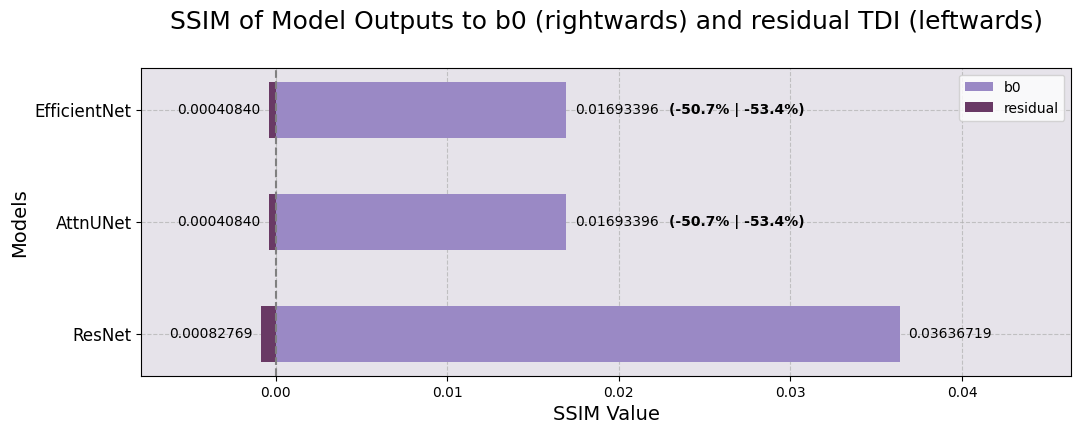

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

models = ['ResNet', 'AttnUNet', 'EfficientNet']
ssim_b0 = [ssim_resnet_b0, ssim_attnunet_b0, ssim_efficientnet_b0]  # SSIM values for each model's output with b0
ssim_residual = [-ssim_resnet_res, -ssim_attnunet_res, -ssim_efficientnet_res]  # SSIM values for each model's output with residual TDI (negated)

# Generate a cubehelix color palette with pinkish and purpleish tones
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.3, light=0.8)
pinkish = color_palette[3]  # Picking the light pink color from the palette
purpleish = color_palette[7]  # Picking the light purple color from the palette

beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]  # Picking a lighter shade from the generated beige palette

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Setting bar width and positions
bar_width = 0.5
r = np.arange(len(models))

# Creating bars with a higher zorder
bars1 = ax.barh(r, ssim_b0, height=bar_width, label='b0', color=pinkish, zorder=2)
bars2 = ax.barh(r, ssim_residual, height=bar_width, label='residual', color=purpleish, zorder=2)


# Adding SSIM values tightly on the bars
for bar in bars1:
    w = bar.get_width()
    ax.text(w + 0.0005, bar.get_y() + bar.get_height()/2, f'{w:.8f}', 
            ha='left', va='center', fontsize=10, color='black')

for bar in bars2:
    w = bar.get_width()
    ax.text(w - 0.0005, bar.get_y() + bar.get_height()/2, f'{-w:.8f}', 
            ha='right', va='center', fontsize=10, color='black')


# Calculate the percentage increase for b0 SSIM
b0_percent_increase_attnunet = ((ssim_attnunet_b0 - ssim_resnet_b0) / ssim_resnet_b0) * 100
b0_percent_increase_efficientnet = ((ssim_efficientnet_b0 - ssim_resnet_b0) / ssim_resnet_b0) * 100

# Calculate the percentage increase for residual SSIM
res_percent_increase_attnunet = ((abs(ssim_attnunet_res) - abs(ssim_resnet_res)) / abs(ssim_resnet_res)) * 100
res_percent_increase_efficientnet = ((abs(ssim_efficientnet_res) - abs(ssim_resnet_res)) / abs(ssim_resnet_res)) * 100

print(f"b0 SSIM percent increase for AttnUNet vs. ResNet: {b0_percent_increase_attnunet:.2f}%")
print(f"b0 SSIM percent increase for EfficientNet vs. ResNet: {b0_percent_increase_efficientnet:.2f}%")
print(f"Residual SSIM percent increase for AttnUNet vs. ResNet: {res_percent_increase_attnunet:.2f}%")
print(f"Residual SSIM percent increase for EfficientNet vs. ResNet: {res_percent_increase_efficientnet:.2f}%")

# # Calculate and add the percentage difference label
# percent_diffs = [(abs(r) / b) * 100 for b, r in zip(ssim_b0, ssim_residual)]
# for i, (bar1, bar2, pdiff) in enumerate(zip(bars1, bars2, percent_diffs)):
#     x = max(bar1.get_width(), bar2.get_width()) + 0.006  # Adjusted this value to move the label further to the right
#     y = bar1.get_y() + bar1.get_height()/2
#     ax.text(x, y, f'({pdiff:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')

# Show the percent increase in SSIM values
percent_increase = [[0, 0],
                    [res_percent_increase_attnunet, b0_percent_increase_attnunet],
                    [res_percent_increase_efficientnet, b0_percent_increase_efficientnet]]
for i, (bar1, bar2, pincrease) in enumerate(zip(bars1, bars2, percent_increase)):
    if i == 0:
        continue
    x = max(bar1.get_width(), bar2.get_width()) + 0.006  # Adjusted this value to move the label further to the right
    y = bar1.get_y() + bar1.get_height()/2
    ax.text(x, y, f'({pincrease[0]:.1f}% | {pincrease[1]:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')


# Adjust the x-axis limits to make the left scale larger
left_limit = min(ssim_residual) - 0.007  # adding a bit more space on the left
right_limit = max(ssim_b0) + 0.01  # little space on the right
ax.set_xlim(left_limit, right_limit)

# Setting labels, title, and ticks
ax.set_ylabel('Models', fontsize=14)
ax.set_xlabel('SSIM Value', fontsize=14)
title = ax.set_title('SSIM of Model Outputs to b0 (rightwards) and residual TDI (leftwards)',
                     fontsize=18, y=1.1)
ax.set_yticks(r)
ax.set_yticklabels(models, fontsize=12)
ax.axvline(0, color='grey', linestyle='--')
ax.legend()

# Set the background color
ax.set_facecolor(beige_color)

# Adding a grid for better readability
ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

plt.show()


## **Normalized Cross-Correlation**

In [14]:
import numpy as np

def compute_NCC(A, B):
    """Compute the Normalized Cross-Correlation (NCC) between two 3D images A and B."""
    
    # Ensure A and B are numpy arrays
    A = np.asarray(A)
    B = np.asarray(B)

    # Get the size of the GT
    gt_x, gt_y, gt_z = B.shape

    # Get the prediction only until the size of the GT
    A = A[:gt_x, :gt_y, :gt_z]
    
    # Check if A and B have the same shape
    if A.shape != B.shape:
        raise ValueError("Both images must have the same shape!")
    
    # Compute the mean values of A and B
    mean_A = np.mean(A)
    mean_B = np.mean(B)
    
    # Compute the numerator (cross-correlation)
    numerator = np.sum((A - mean_A) * (B - mean_B))
    
    # Compute the denominator (product of the standard deviations of A and B)
    denominator = np.sqrt(np.sum((A - mean_A) ** 2) * np.sum((B - mean_B) ** 2))
    
    # Return the NCC
    return numerator / denominator

# Find the NCC between the predictions and the ground truth
ncc_resnet_b0, ncc_resnet_res = compute_NCC(resnet, b0), compute_NCC(resnet, residual)
ncc_attnunet_b0, ncc_attnunet_res = compute_NCC(attnunet, b0), compute_NCC(attnunet, residual)
ncc_efficientnet_b0, ncc_efficientnet_res = compute_NCC(efficientnet, b0), compute_NCC(efficientnet, residual)

print("NCC of resnet_b0: ", ncc_resnet_b0, " | resnet_res: ", ncc_resnet_res)
print("NCC of attnunet_b0: ", ncc_attnunet_b0, " | attnunet_res: ", ncc_attnunet_res)
print("NCC of efficientnet_b0: ", ncc_efficientnet_b0, " | efficientnet_res: ", ncc_efficientnet_res)

NCC of resnet_b0:  0.19442315398443827  | resnet_res:  0.04937202422705661
NCC of attnunet_b0:  0.03644272919281192  | attnunet_res:  0.04800200145873092
NCC of efficientnet_b0:  0.03644272919281192  | efficientnet_res:  0.04800200145873092


b0 NCC percent increase for AttnUNet vs. ResNet: -81.26%
b0 NCC percent increase for EfficientNet vs. ResNet: -81.26%
Residual NCC percent increase for AttnUNet vs. ResNet: -2.77%
Residual NCC percent increase for EfficientNet vs. ResNet: -2.77%


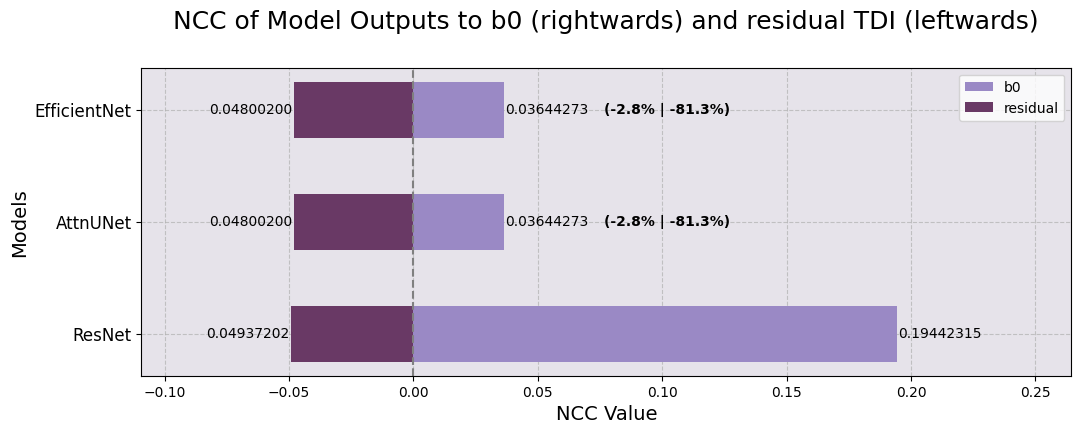

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

models = ['ResNet', 'AttnUNet', 'EfficientNet']
NCC_b0 = [ncc_resnet_b0, ncc_attnunet_b0, ncc_efficientnet_b0]  # ncc values for each model's output with b0
NCC_residual = [-ncc_resnet_res, -ncc_attnunet_res, -ncc_efficientnet_res]  # ncc values for each model's output with residual TDI (negated)

# Generate a cubehelix color palette with pinkish and purpleish tones
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.3, light=0.8)
pinkish = color_palette[3]  # Picking the light pink color from the palette
purpleish = color_palette[7]  # Picking the light purple color from the palette

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Setting bar width and positions
bar_width = 0.5
r = np.arange(len(models))

# Creating bars with a higher zorder
bars1 = ax.barh(r, NCC_b0, height=bar_width, label='b0', color=pinkish, zorder=2)
bars2 = ax.barh(r, NCC_residual, height=bar_width, label='residual', color=purpleish, zorder=2)

# Adding NCC values tightly on the bars
for bar in bars1:
    w = bar.get_width()
    ax.text(w + 0.0005, bar.get_y() + bar.get_height()/2, f'{w:.8f}', 
            ha='left', va='center', fontsize=10, color='black')

for bar in bars2:
    w = bar.get_width()
    ax.text(w - 0.0005, bar.get_y() + bar.get_height()/2, f'{-w:.8f}', 
            ha='right', va='center', fontsize=10, color='black')


# Calculate the percentage increase for b0 NCC
b0_percent_increase_attnunet = ((ncc_attnunet_b0 - ncc_resnet_b0) / ncc_resnet_b0) * 100
b0_percent_increase_efficientnet = ((ncc_efficientnet_b0 - ncc_resnet_b0) / ncc_resnet_b0) * 100

# Calculate the percentage increase for residual NCC
res_percent_increase_attnunet = ((abs(ncc_attnunet_res) - abs(ncc_resnet_res)) / abs(ncc_resnet_res)) * 100
res_percent_increase_efficientnet = ((abs(ncc_efficientnet_res) - abs(ncc_resnet_res)) / abs(ncc_resnet_res)) * 100

print(f"b0 NCC percent increase for AttnUNet vs. ResNet: {b0_percent_increase_attnunet:.2f}%")
print(f"b0 NCC percent increase for EfficientNet vs. ResNet: {b0_percent_increase_efficientnet:.2f}%")
print(f"Residual NCC percent increase for AttnUNet vs. ResNet: {res_percent_increase_attnunet:.2f}%")
print(f"Residual NCC percent increase for EfficientNet vs. ResNet: {res_percent_increase_efficientnet:.2f}%")

# # Calculate and add the percentage difference label
# percent_diffs = [(abs(r) / b) * 100 for b, r in zip(NCC_b0, NCC_residual)]
# for i, (bar1, bar2, pdiff) in enumerate(zip(bars1, bars2, percent_diffs)):
#     x = max(bar1.get_width(), bar2.get_width()) + 0.04  # Adjusted this value to move the label further to the right
#     y = bar1.get_y() + bar1.get_height()/2
#     ax.text(x, y, f'({pdiff:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')

# Show the percent increase in NCC values
percent_increase = [[0, 0],
                    [res_percent_increase_attnunet, b0_percent_increase_attnunet],
                    [res_percent_increase_efficientnet, b0_percent_increase_efficientnet]]
for i, (bar1, bar2, pincrease) in enumerate(zip(bars1, bars2, percent_increase)):
    if i == 0:
        continue
    x = max(bar1.get_width(), bar2.get_width()) + 0.04  # Adjusted this value to move the label further to the right
    y = bar1.get_y() + bar1.get_height()/2
    ax.text(x, y, f'({pincrease[0]:.1f}% | {pincrease[1]:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')



# Adjust the x-axis limits to make the left scale larger
left_limit = min(NCC_residual) - 0.06  # adding a bit more space on the left
right_limit = max(NCC_b0) + 0.07  # little space on the right
ax.set_xlim(left_limit, right_limit)

# Setting labels, title, and ticks
ax.set_ylabel('Models', fontsize=14)
ax.set_xlabel('NCC Value', fontsize=14)
title = ax.set_title('NCC of Model Outputs to b0 (rightwards) and residual TDI (leftwards)',
                     fontsize=18, y=1.1)
ax.set_yticks(r)
ax.set_yticklabels(models, fontsize=12)
ax.axvline(0, color='grey', linestyle='--')
ax.legend()

# Set the background color
ax.set_facecolor(beige_color)

# Adding a grid for better readability
ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

plt.show()


## **Peak Signal-to-Noise Ratio**

In [16]:
import numpy as np

def mse(imageA, imageB):
    # Compute the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * imageA.shape[2])
    return err

def compute_PSNR(imageA, imageB):

    # Get the size of the GT
    gt_x, gt_y, gt_z = imageB.shape

    # Get the prediction only until the size of the GT
    imageA = imageA[:gt_x, :gt_y, :gt_z]
    
    # Compute MSE
    err = mse(imageA, imageB)
    
    # Avoid division by zero
    if err == 0:
        return float('inf')
    
    # Assume image data is uint8, so maximum value is 255
    # Change this if you have different range
    MAX_I = 255.0
    
    # Compute PSNR
    PSNR = 10 * np.log10(MAX_I**2 / err)
    
    return PSNR

# Find the PSNR between the predictions and the ground truth
PSNR_resnet_b0, PSNR_resnet_res = compute_PSNR(resnet, b0), compute_PSNR(resnet, residual)
PSNR_attnunet_b0, PSNR_attnunet_res = compute_PSNR(attnunet, b0), compute_PSNR(attnunet, residual)
PSNR_efficientnet_b0, PSNR_efficientnet_res = compute_PSNR(efficientnet, b0), compute_PSNR(efficientnet, residual)

print("PSNR of resnet_b0: ", PSNR_resnet_b0, " | resnet_res: ", PSNR_resnet_res)
print("PSNR of attnunet_b0: ", PSNR_attnunet_b0, " | attnunet_res: ", PSNR_attnunet_res)
print("PSNR of efficientnet_b0: ", PSNR_efficientnet_b0, " | efficientnet_res: ", PSNR_efficientnet_res)

PSNR of resnet_b0:  12.38837232149856  | resnet_res:  11.720512175344274
PSNR of attnunet_b0:  10.445547903236053  | attnunet_res:  19.72949463506058
PSNR of efficientnet_b0:  10.445547903236053  | efficientnet_res:  19.72949463506058


b0 PSNR percent increase for AttnUNet vs. ResNet: -15.68%
b0 PSNR percent increase for EfficientNet vs. ResNet: -15.68%
Residual PSNR percent increase for AttnUNet vs. ResNet: 68.33%
Residual PSNR percent increase for EfficientNet vs. ResNet: 68.33%


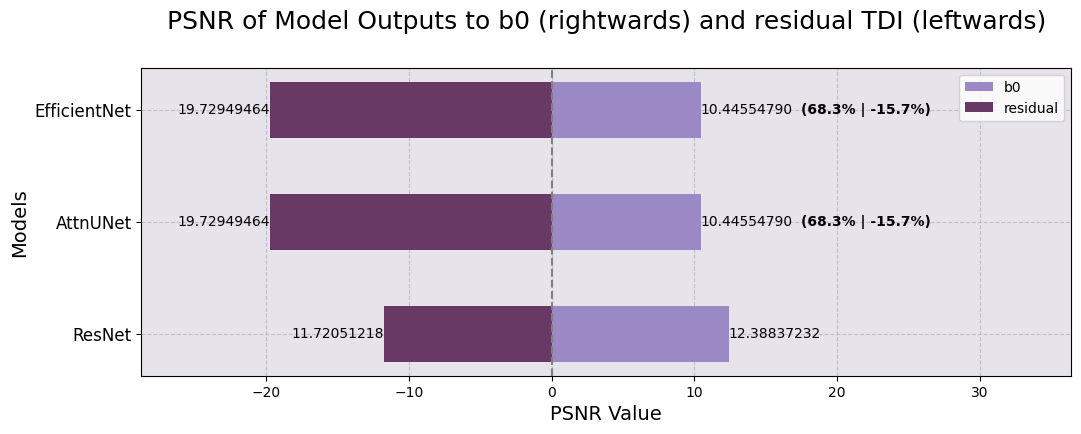

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

models = ['ResNet', 'AttnUNet', 'EfficientNet']
PSNR_b0 = [PSNR_resnet_b0, PSNR_attnunet_b0, PSNR_efficientnet_b0]  # PSNR values for each model's output with b0
PSNR_residual = [-PSNR_resnet_res, -PSNR_attnunet_res, -PSNR_efficientnet_res]  # PSNR values for each model's output with residual TDI (negated)

# Generate a cubehelix color palette with pinkish and purpleish tones
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.3, light=0.8)
pinkish = color_palette[3]  # Picking the light pink color from the palette
purpleish = color_palette[7]  # Picking the light purple color from the palette

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Setting bar width and positions
bar_width = 0.5
r = np.arange(len(models))

# Creating bars with a higher zorder
bars1 = ax.barh(r, PSNR_b0, height=bar_width, label='b0', color=pinkish, zorder=2)
bars2 = ax.barh(r, PSNR_residual, height=bar_width, label='residual', color=purpleish, zorder=2)


# Adding PSNR values tightly on the bars
for bar in bars1:
    w = bar.get_width()
    ax.text(w + 0.0005, bar.get_y() + bar.get_height()/2, f'{w:.8f}', 
            ha='left', va='center', fontsize=10, color='black')

for bar in bars2:
    w = bar.get_width()
    ax.text(w - 0.0005, bar.get_y() + bar.get_height()/2, f'{-w:.8f}', 
            ha='right', va='center', fontsize=10, color='black')


# Calculate the percentage increase for b0 PSNR
b0_percent_increase_attnunet = ((PSNR_attnunet_b0 - PSNR_resnet_b0) / PSNR_resnet_b0) * 100
b0_percent_increase_efficientnet = ((PSNR_efficientnet_b0 - PSNR_resnet_b0) / PSNR_resnet_b0) * 100

# Calculate the percentage increase for residual PSNR
res_percent_increase_attnunet = ((abs(PSNR_attnunet_res) - abs(PSNR_resnet_res)) / abs(PSNR_resnet_res)) * 100
res_percent_increase_efficientnet = ((abs(PSNR_efficientnet_res) - abs(PSNR_resnet_res)) / abs(PSNR_resnet_res)) * 100

print(f"b0 PSNR percent increase for AttnUNet vs. ResNet: {b0_percent_increase_attnunet:.2f}%")
print(f"b0 PSNR percent increase for EfficientNet vs. ResNet: {b0_percent_increase_efficientnet:.2f}%")
print(f"Residual PSNR percent increase for AttnUNet vs. ResNet: {res_percent_increase_attnunet:.2f}%")
print(f"Residual PSNR percent increase for EfficientNet vs. ResNet: {res_percent_increase_efficientnet:.2f}%")

# # Calculate and add the percentage difference label
# percent_diffs = [(abs(r) / b) * 100 for b, r in zip(PSNR_b0, PSNR_residual)]
# for i, (bar1, bar2, pdiff) in enumerate(zip(bars1, bars2, percent_diffs)):
#     x = max(bar1.get_width(), bar2.get_width()) + 0.04  # Adjusted this value to move the label further to the right
#     y = bar1.get_y() + bar1.get_height()/2
#     ax.text(x, y, f'({pdiff:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')

# Show the percent increase in PSNR values
percent_increase = [[0, 0],
                    [res_percent_increase_attnunet, b0_percent_increase_attnunet],
                    [res_percent_increase_efficientnet, b0_percent_increase_efficientnet]]
for i, (bar1, bar2, pincrease) in enumerate(zip(bars1, bars2, percent_increase)):
    if i == 0:
        continue
    x = max(bar1.get_width(), bar2.get_width()) + 7  # Adjusted this value to move the label further to the right
    y = bar1.get_y() + bar1.get_height()/2
    ax.text(x, y, f'({pincrease[0]:.1f}% | {pincrease[1]:.1f}%)', ha='left', va='center', fontsize=10, weight='bold', color='black')

# Set the background color
ax.set_facecolor(beige_color)


# Adjust the x-axis limits to make the left scale larger
left_limit = min(PSNR_residual) - 9  # adding a bit more space on the left
right_limit = max(PSNR_b0) + 24  # little space on the right
ax.set_xlim(left_limit, right_limit)

# Setting labels, title, and ticks
ax.set_ylabel('Models', fontsize=14)
ax.set_xlabel('PSNR Value', fontsize=14)
title = ax.set_title('PSNR of Model Outputs to b0 (rightwards) and residual TDI (leftwards)',
                     fontsize=18, y=1.1)
ax.set_yticks(r)
ax.set_yticklabels(models, fontsize=12)
ax.axvline(0, color='grey', linestyle='--')
ax.legend()

# Adding a grid for better readability
ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

plt.show()
